### Transcription factor analysis of novel macrophage phenotypes (Dorothea)

In [40]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import warnings
import anndata
warnings.filterwarnings('ignore')


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './final-figures/merged/myeloid/functional_analysis/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anndata2ri          1.0.6
backcall            0.2.0
cairo               1.20.0
cffi                1.14.5
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
markupsafe          1.1.1
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.19.5
packaging           20.9
pandas              1.2.2
parso               0.8.1
pexpect             4.8.0
picklesha

'/home/jovyan/my-conda-envs/scanpy_env/bin/python'

In [41]:
import rpy2
print(rpy2.__version__)

3.4.2


In [42]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [43]:
import anndata2ri
anndata2ri.activate()

In [44]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [45]:
%%R

library(dplyr)
library(Seurat)
library(tibble)
library(pheatmap)
library(tidyr)

In [46]:
%%R
R.version.string

[1] "R version 4.0.4 (2021-02-15)"


In [47]:
%%R 

#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

#BiocManager::install("viper")
library(viper)

In [48]:
%%R 

#BiocManager::install("dorothea")
library(dorothea)

#### Load data 

In [49]:
path_to_gonads = '/nfs/team292/vl6/immune_fetal_gonads/'

In [50]:
adata = sc.read(path_to_gonads + 'macrophages.h5ad')

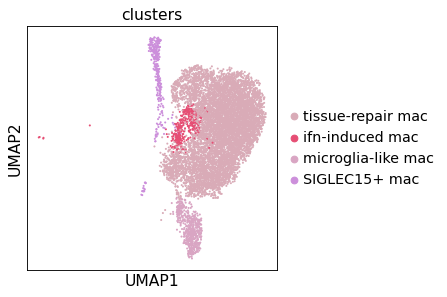

In [51]:
sc.pl.umap(adata, color = 'clusters')

#### Convert to Seurat object 

In [52]:
import numpy as np
from scipy import sparse

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.conversion import localconverter

ro.r("library(Matrix)")

def csr_to_dgc(csr):
    """Convert (and transpose) a csr matrix from python to a R dgCMatrix (not sure if type is consistent)
    """
    numeric = ro.r("as.numeric")
    with localconverter(ro.default_converter + ro.numpy2ri.converter):
        X = ro.r("sparseMatrix")(
            i=numeric(csr.indices),
            p=numeric(csr.indptr),
            x=numeric(csr.data),
            dims=list(csr.shape[::-1]),
            index1=False
        )
    return X

In [53]:
rawcounts_R = csr_to_dgc(adata.raw.X)
rawcounts_R

<rpy2.robjects.methods.RS4 object at 0x7fae2df53d80> [RTYPES.S4SXP]
R classes: ('dgCMatrix',)

In [54]:
%%R -i rawcounts_R -o rawcounts_dgT

rawcounts_dgT <- as(rawcounts_R, "dgTMatrix")
print(dim(rawcounts_dgT)) # Check the shape of the matrix 

[1] 28497  8875


In [55]:
metadata_cell = adata.obs
print(metadata_cell.shape)
metadata_gene = adata.raw.var
print(metadata_gene.shape)

(8875, 59)
(28497, 194)


In [56]:
%%R -i rawcounts_dgT -i metadata_cell -i metadata_gene 

rownames(rawcounts_dgT) <- rownames(metadata_gene) # Add rownames 
colnames(rawcounts_dgT) <- rownames(metadata_cell) # Add colnames 

In [57]:
%%R -o macro_Seurat -i metadata_cell

macro_Seurat <- CreateSeuratObject(
    counts = rawcounts_dgT,
    assay = "RNA",
    meta.data = metadata_cell,
  )
macro_Seurat

An object of class Seurat 
28497 features across 8875 samples within 1 assay 
Active assay: RNA (28497 features, 0 variable features)


In [58]:
%%R 
## Normalizing the data
macro_Seurat <- NormalizeData(macro_Seurat, normalization.method = "LogNormalize", 
    scale.factor = 10000)

macro_Seurat <- NormalizeData(macro_Seurat)

## Identify the 2000 most highly variable genes
macro_Seurat <- FindVariableFeatures(macro_Seurat, selection.method = "vst", nfeatures = 2000)

## In addition we scale the data
all.genes <- rownames(macro_Seurat)
macro_Seurat <- ScaleData(macro_Seurat, features = all.genes)

In [59]:
%%R 

macro_Seurat <- RunPCA(macro_Seurat, features = VariableFeatures(object = macro_Seurat), 
               verbose = FALSE)
macro_Seurat <- FindNeighbors(macro_Seurat, dims = 1:30, verbose = FALSE)
macro_Seurat <- FindClusters(macro_Seurat, resolution = 0.1, verbose = FALSE)
macro_Seurat <- RunUMAP(macro_Seurat, dims = 1:30, umap.method = "uwot", metric = "cosine")

macro_Seurat.markers <- FindAllMarkers(macro_Seurat, only.pos = TRUE, min.pct = 0.25, 
                               logfc.threshold = 0.25, verbose = FALSE)

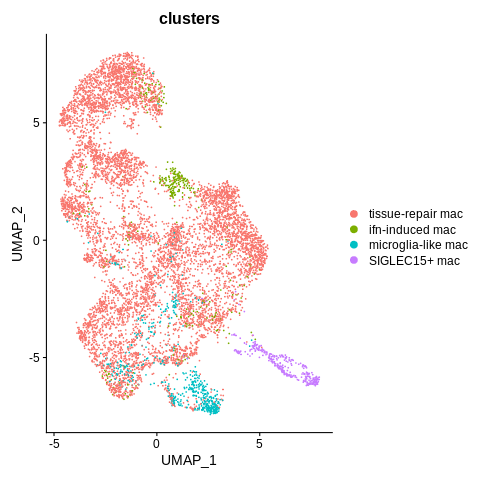

In [60]:
%%R 

DimPlot(object = macro_Seurat, group.by = "clusters")

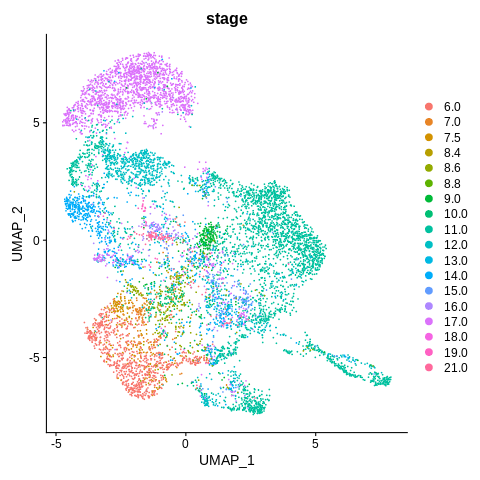

In [61]:
%%R 

DimPlot(object = macro_Seurat, group.by = "stage")

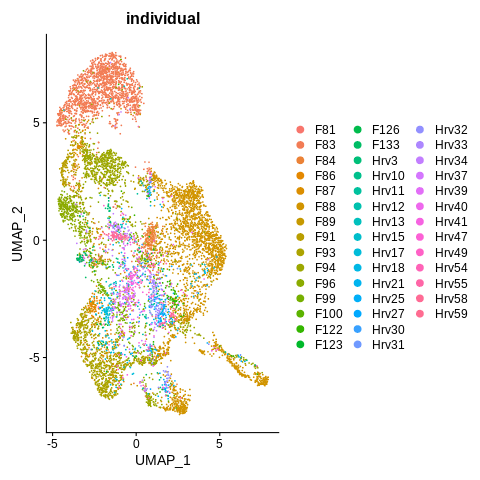

In [62]:
%%R 

DimPlot(object = macro_Seurat, group.by = "individual")

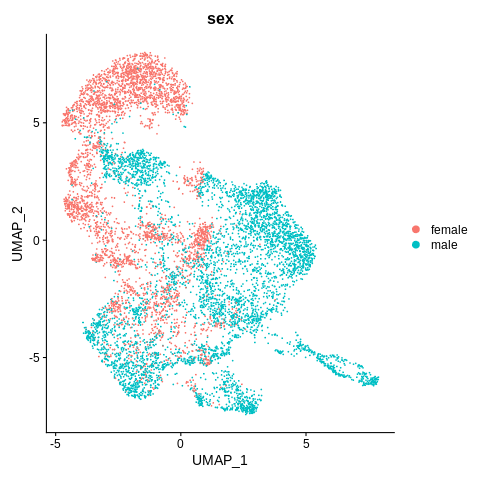

In [63]:
%%R 

DimPlot(object = macro_Seurat, group.by = "sex")

#### Run Dorothea to compute TF activities per cluster

In [64]:
%%R 

## We read Dorothea Regulons for Human:
dorothea_regulon_human <- get(data("dorothea_hs", package = "dorothea"))

## We obtain the regulons based on interactions with confidence level A, B, C
regulon <- dorothea_regulon_human %>%
    dplyr::filter(confidence %in% c("A","B","C","D"))

## We compute Viper Scores 
macro_Seurat <- run_viper(macro_Seurat, regulon,
                  options = list(method = "scale", minsize = 4, 
                                 eset.filter = FALSE, cores = 1, 
                                 verbose = FALSE))

In [65]:
%%R 

## We compute the Nearest Neighbours to perform cluster
DefaultAssay(object = macro_Seurat) <- "dorothea"
macro_Seurat <- ScaleData(macro_Seurat)
macro_Seurat <- RunPCA(macro_Seurat, features = rownames(macro_Seurat), verbose = FALSE)
macro_Seurat <- FindNeighbors(macro_Seurat, dims = 1:10, verbose = FALSE)
macro_Seurat <- FindClusters(macro_Seurat, resolution = 0.5, verbose = FALSE)

macro_Seurat <- RunUMAP(macro_Seurat, dims = 1:10, umap.method = "uwot", metric = "cosine")

macro_Seurat.markers <- FindAllMarkers(macro_Seurat, only.pos = TRUE, min.pct = 0.25, 
                               logfc.threshold = 0.25, verbose = FALSE)

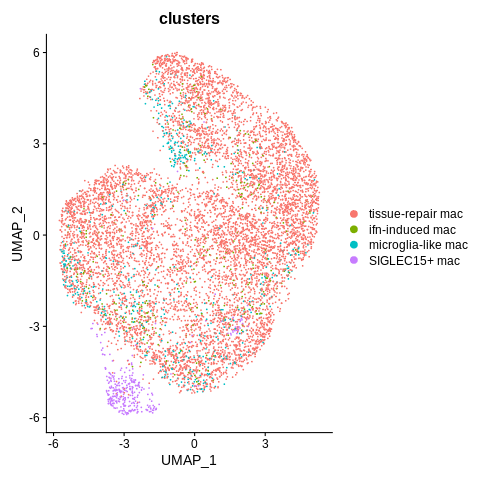

In [66]:
%%R 

DimPlot(object = macro_Seurat, group.by = "clusters")

In [67]:
%%R -o summarized_viper_scores

## We transform Viper scores, scaled by seurat, into a data frame to better 
## handling the results
viper_scores_df <- GetAssayData(macro_Seurat, slot = "scale.data", 
                                    assay = "dorothea") %>%
  data.frame(check.names = F) %>%
  t()

## We create a data frame containing the cells and their clusters
CellsClusters <- data.frame(cell = names(Idents(macro_Seurat)), 
                            cell_type = as.character(macro_Seurat@meta.data$clusters),
                            check.names = F)

## We create a data frame with the Viper score per cell and its clusters
viper_scores_clusters <- viper_scores_df  %>%
  data.frame() %>% 
  rownames_to_column("cell") %>%
  gather(tf, activity, -cell) %>%
  inner_join(CellsClusters)

## We summarize the Viper scores by cellpopulation
summarized_viper_scores <- viper_scores_clusters %>% 
  group_by(tf, cell_type) %>%
  summarise(avg = mean(activity),
            std = sd(activity))

Joining, by = "cell"
`summarise()` has grouped output by 'tf'. You can override using the `.groups` argument.


In [74]:
%%R -o summarized_viper_scores_df

highly_variable_tfs <- summarized_viper_scores %>%
  group_by(tf) %>%
  mutate(var = var(avg))  %>%
  ungroup() %>%
  top_n(120, var) %>%
  distinct(tf)

## We prepare the data for the plot
summarized_viper_scores_df <- summarized_viper_scores %>%
  semi_join(highly_variable_tfs, by = "tf") %>%
  dplyr::select(-std) %>%   
  spread(tf, avg) %>%
  data.frame(row.names = 1, check.names = FALSE) 

In [72]:
summarized_viper_scores_df

,ADNP,AHR,AR,ARID2,ARID3A,ARNT,ARNTL,ASCL1,ATF1,ATF2,...,ZNF589,ZNF592,ZNF639,ZNF644,ZNF740,ZNF750,ZNF766,ZNF83,ZNF92,ZZZ3
ifn-induced mac,-0.199904,-0.237656,0.232250,-0.135961,-0.175121,-0.025940,-0.220229,-0.444791,0.198617,-0.253227,...,-0.124208,-0.188637,-0.005312,-0.127806,-0.046134,-0.259329,0.000595,-0.220583,-0.351320,0.021536
microglia-like mac,-0.279861,-0.248389,0.073444,-0.205281,-0.504018,-0.386426,-0.423588,-0.398346,-0.076768,-0.199097,...,-0.283071,-0.053968,-0.003405,-0.412659,-0.061626,-0.532932,-0.159895,-0.243055,-0.620935,-0.071431
SIGLEC15+ mac,-0.625483,-0.446098,0.618742,0.108582,-0.730757,-0.383941,-0.556385,-0.418861,-0.737834,-1.307246,...,-1.023908,0.316550,-0.479830,-0.128496,0.672406,-0.335336,0.325858,-0.694923,-1.188324,0.630583
tissue-repair mac,0.057290,0.048945,-0.043038,0.017029,0.077478,0.046742,0.066024,0.068656,0.028356,0.083158,...,0.071206,-0.000835,0.021220,0.042424,-0.022265,0.066495,-0.002115,0.058494,0.114204,-0.022877


In [73]:
summarized_viper_scores_df.to_csv('/home/jovyan/Macrophages_TFs.csv')

In [75]:
%%R 

palette_length = 100
my_color = colorRampPalette(c("Darkblue", "white","red"))(palette_length)

my_breaks <- c(seq(min(summarized_viper_scores_df), 0, 
                   length.out=ceiling(palette_length/2) + 1),
               seq(max(summarized_viper_scores_df)/palette_length, 
                   max(summarized_viper_scores_df), 
                   length.out=floor(palette_length/2)))

viper_hmap <- pheatmap(t(summarized_viper_scores_df),fontsize=14, 
                       fontsize_row = 12, 
                       color=my_color, breaks = my_breaks, 
                       main = "DoRothEA", angle_col = 45,
                       treeheight_col = 0,  border_color = "black", filename = "/home/jovyan/Gonads/Males_and_Females/final-figures/merged/myeloid/functional_analysis/dorothea.pdf") 

#### End of notebook